# Eksploracyjna analiza danych

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

sns.set_theme()

In [3]:
path = "../working/data/raw/sales_ads_train.csv"
df = pd.read_csv(path)
path = "../working/data/raw/sales_ads_test.csv"
df_test = pd.read_csv(path)

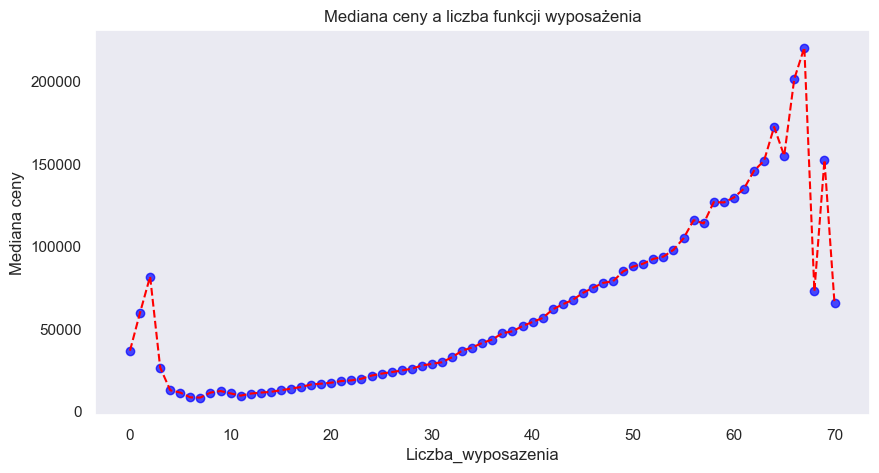

In [6]:
def count_equipment(equipment_str):
    try:
        equipment_list = ast.literal_eval(equipment_str)  
        if isinstance(equipment_list, list):
            return len(equipment_list)  
    except (SyntaxError, ValueError):
        return 0  
    return 0

df["Liczba_wyposazenia"] = df["Wyposazenie"].apply(count_equipment)
median_prices = df.groupby("Liczba_wyposazenia")["Cena"].median().reset_index()
plt.figure(figsize=(10, 5))
plt.scatter(median_prices["Liczba_wyposazenia"], median_prices["Cena"], alpha=0.7, color="blue")
plt.plot(median_prices["Liczba_wyposazenia"], median_prices["Cena"], linestyle='--', color='red')  # Add trendline
plt.xlabel("Liczba_wyposazenia")
plt.ylabel("Mediana ceny")
plt.title("Mediana ceny a liczba funkcji wyposażenia")
plt.grid()
plt.show()

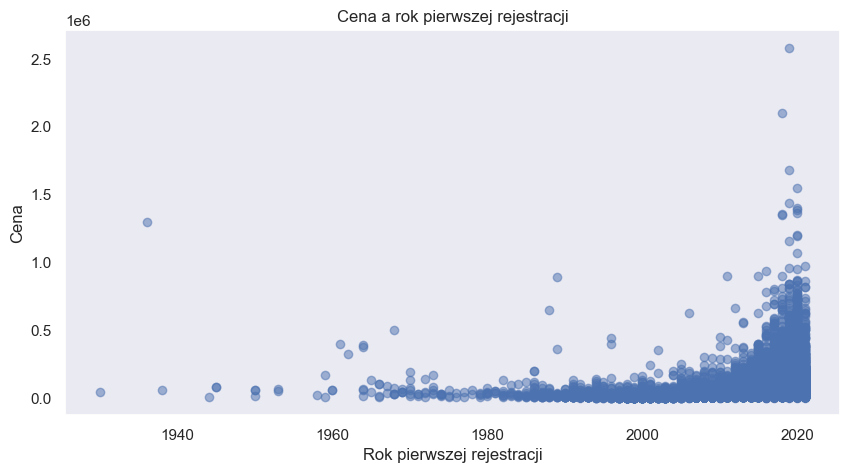

In [7]:
df["Data_pierwszej_rejestracji"] = pd.to_datetime(df["Data_pierwszej_rejestracji"], errors="coerce", dayfirst=True)
df["rok_rejestracji"] = df["Data_pierwszej_rejestracji"].dt.year
df = df[(df["rok_rejestracji"] <= 2021) & (df["rok_rejestracji"] >= 1930)]
plt.figure(figsize=(10, 5))
plt.scatter(df["rok_rejestracji"], df["Cena"], alpha=0.5)
plt.xlabel("Rok pierwszej rejestracji")
plt.ylabel("Cena")
plt.title("Cena a rok pierwszej rejestracji")
plt.grid()
plt.show()